In [3]:
from datetime import date
from sqlalchemy import create_engine
import calendar

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(font_scale=1.5)
%matplotlib inline

In [15]:
def enhance_flights_by_day_of_week(data):
    # Provide human readable names for Day of week
    data['dow'] = data['dow_int'].apply(lambda x: calendar.day_abbr[x - 1])
    
    # Calculate the fraction of the total flights that occured on a given day of the week
    data['fraction_delayed'] = data['delays'] / data['flights']
    return data

def get_day_of_week_statistics(start_date=None, end_date=None, path_to_db=None):
    path_to_db = "sqlite:///../../data/processed/airlines.db"
    engine = create_engine(path_to_db)
    with engine.connect() as conn:
        flights = pd.read_sql("""
            SELECT 
                f.day_of_week as dow_int,
                f.year as year,
                sum(f.flights) as flights,
                sum(f.departure_was_delayed_15) as delays
            FROM 
                flights AS f
            WHERE
                f.year IN (2013, 2014, 2015, 2016, 2017) 
            GROUP BY 
                f.year, f.day_of_week
        """, conn)
    
    return enhance_flights_by_day_of_week(flights)
        
flights = get_day_of_week_statistics()  

In [16]:
flights.head(8)

,dow_int,year,flights,delays,dow,fraction_delayed
0,1,2013,949139,196347,Mon,0.206869
1,2,2013,929959,164568,Tue,0.176963
2,3,2013,931240,168967,Wed,0.181443
3,4,2013,944819,200514,Thu,0.212225
4,5,2013,952033,198760,Fri,0.208774
5,6,2013,767525,129217,Sat,0.168355
6,7,2013,894767,172983,Sun,0.193327
7,1,2014,867299,182671,Mon,0.210621


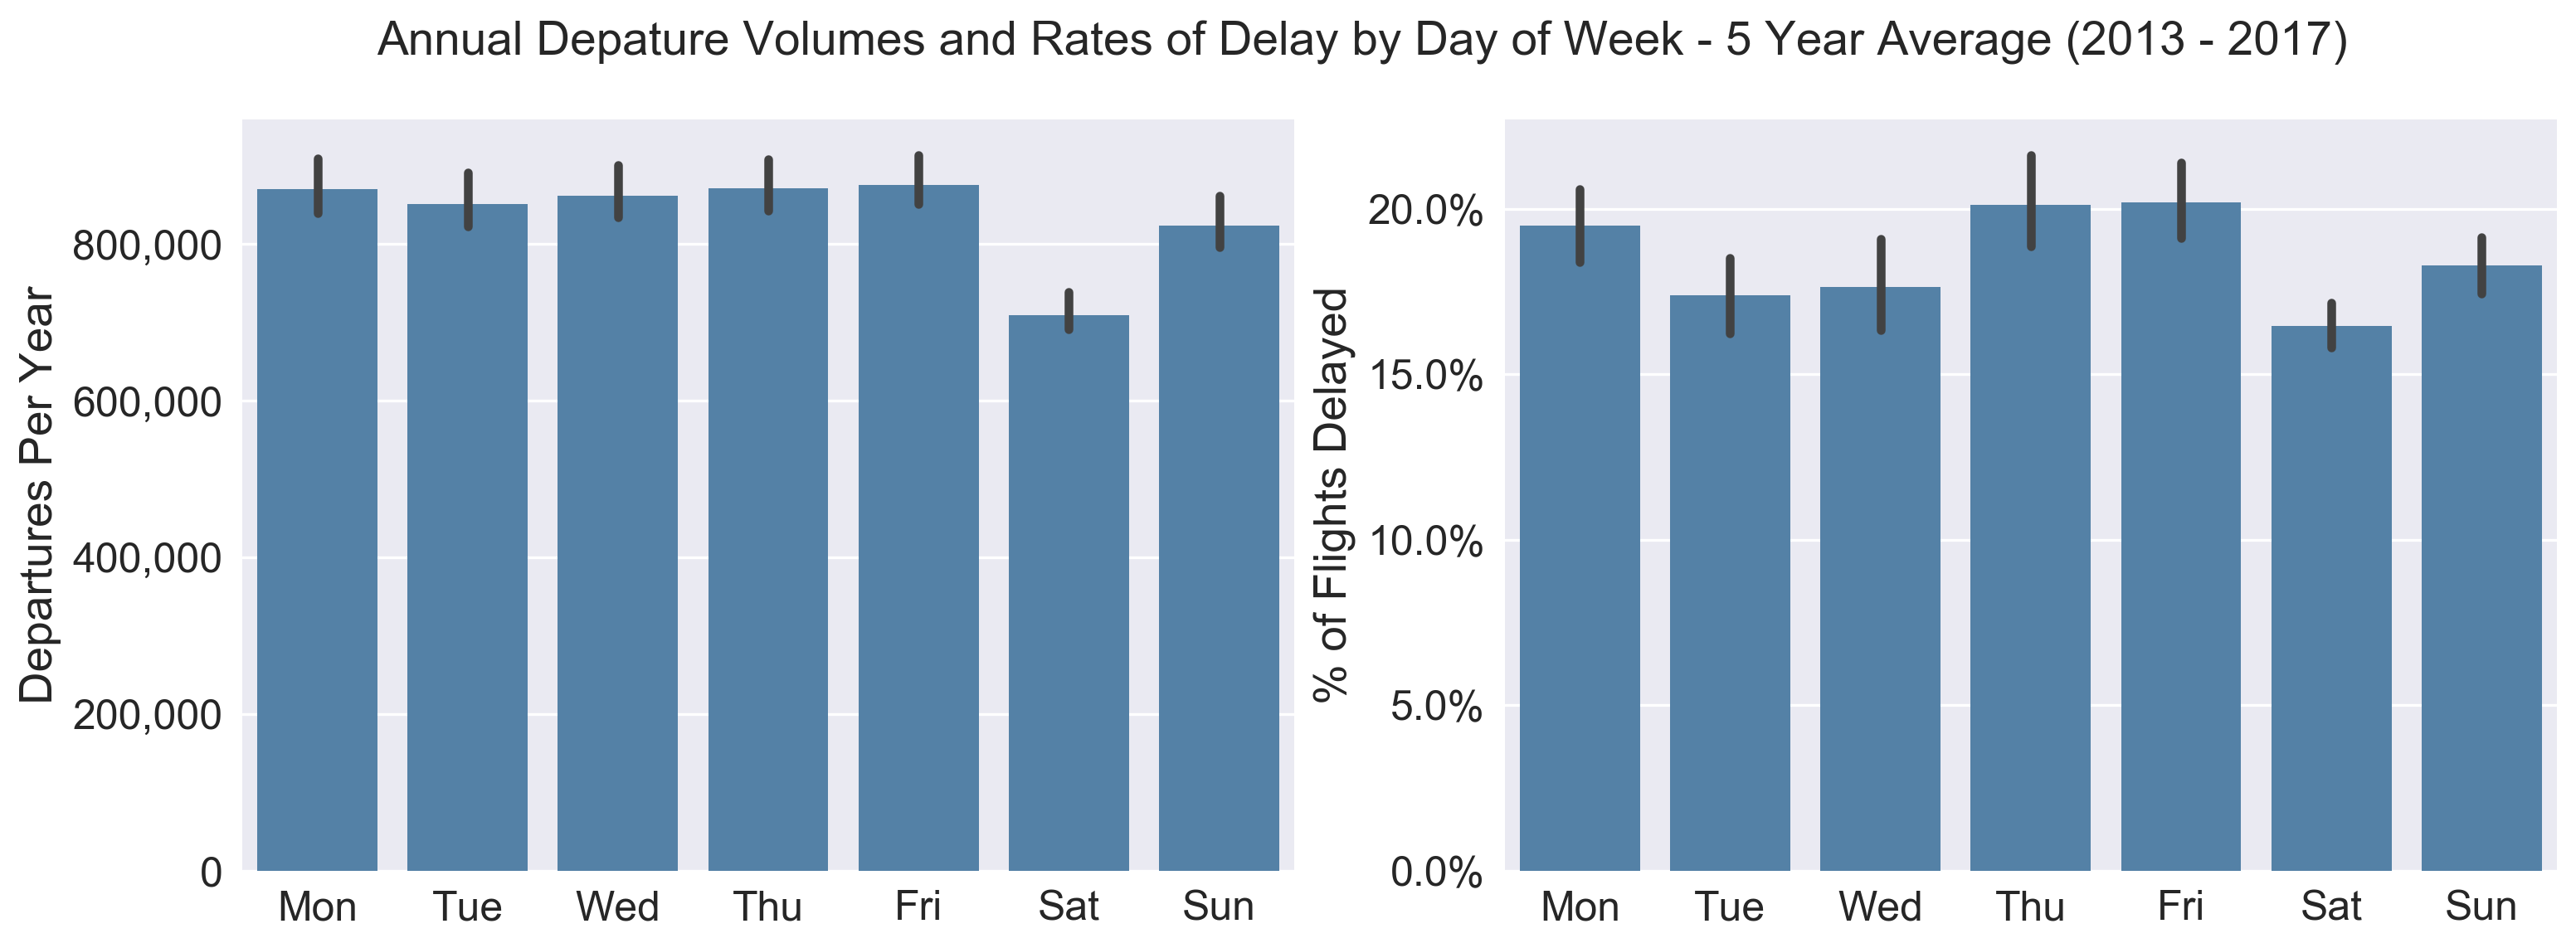

In [29]:
def make_day_of_week_plots(flights):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=240)

    _ = sns.barplot(data=flights, x='dow', y='flights', ax=ax1, color='steelblue')
    _ = ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Departures Per Year')

    _ = sns.barplot(data=flights, x='dow', y='fraction_delayed', ax=ax2, color='steelblue')
    _ = ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{round(x*100, 2)}%"))
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('% of Flights Delayed')

    plt.suptitle('Annual Depature Volumes and Rates of Delay by Day of Week - 5 Year Average (2013 - 2017)', fontsize=17)
    plt.savefig("../../reports/figures/departures-by-day-of-week.png", bbox_inches='tight')

    plt.show()
    
make_day_of_week_plots(flights)